# Importing libraries

In [5]:
from collections import defaultdict
from typing import Optional

import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame
from pydantic import BaseModel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.model_selection import train_test_split


# Configuring pandas

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# Loading datasets

In [201]:
from pydantic import Field, validator


class DF(DataFrame):
    @classmethod
    def __get_validators__(cls):
        yield cls.validate

    @classmethod
    def validate(cls, v):
        if not isinstance(v, DataFrame):
            raise ValueError('Expected DataFrame from pandas')
        return v

    def __repr__(self):
        return f'DataFrame({super().__repr__()})'

    def __str__(self):
        return f'DataFrame({super().__str__()})'


class Dataset(BaseModel):
    class Config:
        arbitrary_types_allowed = True
        repr_html = True
        validate_assignment = True


    name: str
    x: DF = Field(repr=False)
    y: DF = Field(repr=False)

    x_train: Optional[DF]
    y_train: Optional[DF]
    x_test: Optional[DF]
    y_test: Optional[DF]

    y_pred: Optional[DF]
    scores_pred: Optional[DF]

    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.4, shuffle=True)
        return self

In [202]:
def dataset_loader(dataset_names: tuple, verbose: bool = False):
    datasets = defaultdict(Dataset)
    for dataset_name in dataset_names:
        raw_data = scipy.io.loadmat(f'../datasets/{dataset_name}.mat')

        x = np.array(raw_data.get('X'))
        y = np.array(raw_data.get('y')).ravel().astype(dtype=np.uint8)

        # TODO: split into train and test dataset, use splitted datasets in experiments
        dataset = Dataset(
            name=dataset_name,
            x=DataFrame(x),
            y=DataFrame(y),
        ).split_data()
        if verbose:
            print(
                f"Name: {dataset.name}\n"
                f"X: {dataset.x.shape}\n"
                f"Y: {dataset.y.shape}\n"
            )
        datasets[dataset_name] = dataset
    return datasets

In [203]:
datasets = dataset_loader(dataset_names=('pima', 'pendigits', 'cardio'), verbose=True)

Name: pima
X: (768, 8)
Y: (768, 1)

Name: pendigits
X: (6870, 16)
Y: (6870, 1)

Name: cardio
X: (1831, 21)
Y: (1831, 1)



# Statistics

In [205]:
def correlation_map(dataset: Dataset, figsize=(20, 20)):
    # get correlations of each features in dataset
    corrmat = dataset.x.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=figsize)
    #plot heat map
    g = sns.heatmap(dataset.x[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [213]:
def accuracy_report(dataset: Dataset):
    n_errors = int((pima.y_pred != pima.y_test).sum().iloc[0])
    print(f"Number of errors : {n_errors}")
    print("Accuracy Score :", accuracy_score(dataset.y_test, dataset.y_pred))
    print("Classification Report :\n", classification_report(dataset.y_test, dataset.y_pred))

In [207]:
def conf_matrix_plot(dataset: Dataset):
    cm = confusion_matrix(dataset.y, dataset.y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

In [217]:
def roc_curve_plot(datasets: dict[str, Dataset]):
    for name, dataset in datasets.items():
        fpr, tpr, thresh = roc_curve(dataset.y_test, dataset.scores_pred)
        auc = roc_auc_score(dataset.y_test, dataset.scores_pred)
        plt.plot(tpr, fpr, label=f"Dataset: {dataset.name}, auc={round(1 - auc, 3)}")

    plt.plot([0, 1], [0, 1], "k--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc=0)
    plt.show()

# PIMA dataset

In [209]:
pima = datasets["pima"]
pima.x.head()

,0,1,2,3,4,5,6,7
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0


In [115]:
pima.x.describe()

,0,1,2,3,4,5,6,7
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>]],
      dtype=object)

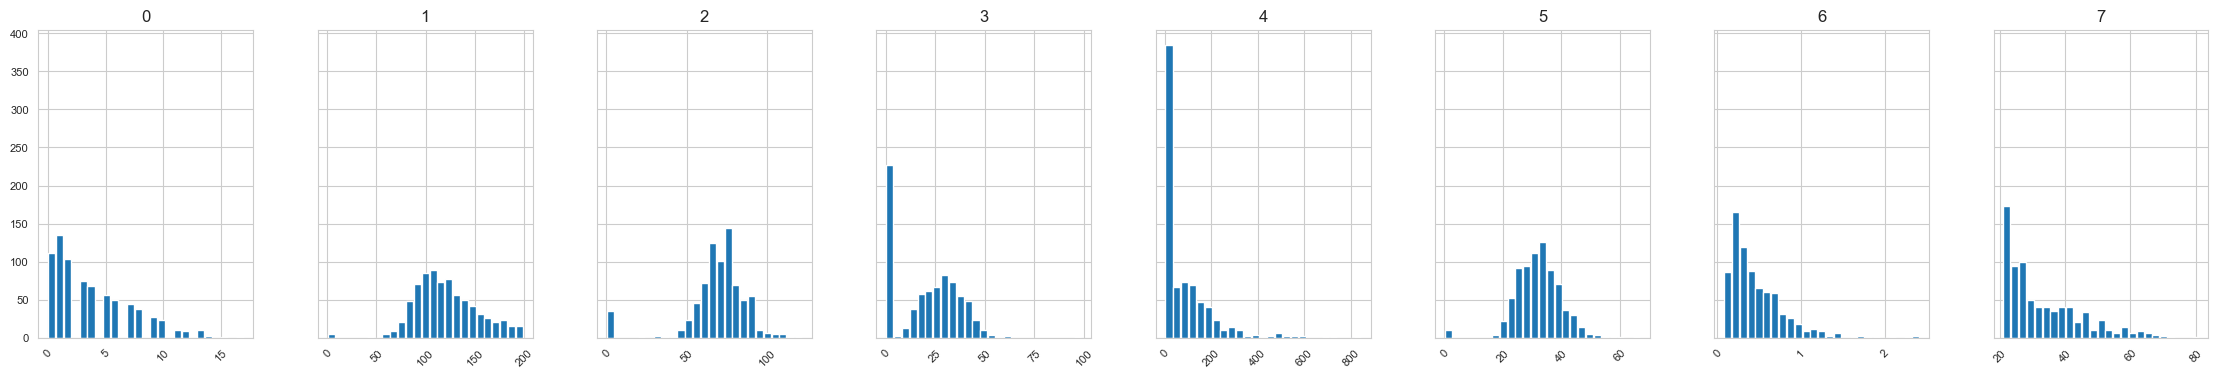

In [116]:
pima.x.hist(figsize=(28, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 8), sharey=True, zorder=2,
            rwidth=0.9)

In [117]:
pima.y.describe()

,0
count,768.000
mean,0.349
std,0.477
min,0.000
25%,0.000
50%,0.000
75%,1.000
max,1.000


In [118]:
pima.y.value_counts()

0    500
1    268
Name: count, dtype: int64

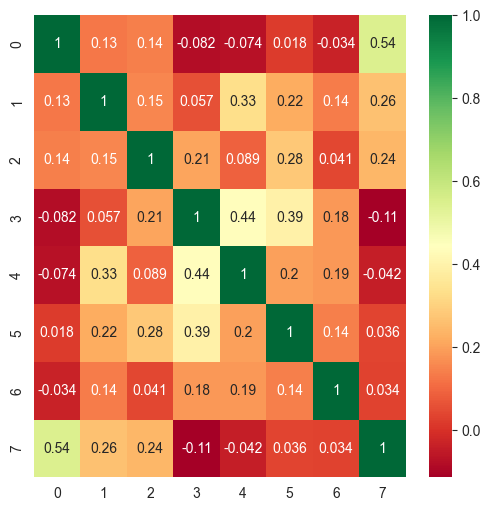

In [119]:
correlation_map(pima, figsize=(6, 6))

# Pendigits dataset

In [121]:
pendigits = datasets["pendigits"]
pendigits.x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.47,1.000,0.270,0.813,0.578,0.372,0.262,0.000,0.000,0.234,0.565,0.533,1.000,0.901,0.402,0.983
1,0.00,0.887,0.276,1.000,0.421,0.758,0.296,0.449,0.151,0.151,0.377,0.000,0.690,0.019,1.000,0.057
2,0.00,0.568,0.322,0.682,0.730,0.903,1.000,1.000,0.759,0.752,0.505,0.506,0.285,0.256,0.163,0.000
3,0.00,1.000,0.071,0.919,0.047,0.687,0.189,0.457,0.864,0.345,1.000,0.456,0.754,0.231,0.660,0.000
4,0.00,0.671,0.482,0.827,1.000,1.000,0.818,0.802,0.597,0.603,0.399,0.403,0.321,0.201,0.459,0.000


In [122]:
pendigits.x.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000,6870.000
mean,0.374,0.843,0.430,0.853,0.543,0.695,0.515,0.482,0.545,0.343,0.591,0.328,0.547,0.310,0.491,0.243
std,0.340,0.171,0.255,0.177,0.343,0.238,0.310,0.294,0.335,0.279,0.374,0.257,0.222,0.299,0.421,0.338
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.019,0.760,0.246,0.741,0.223,0.542,0.273,0.283,0.269,0.059,0.207,0.103,0.419,0.052,0.000,0.000
50%,0.311,0.887,0.422,0.933,0.605,0.735,0.544,0.458,0.564,0.338,0.709,0.283,0.526,0.257,0.453,0.051
75%,0.625,1.000,0.595,1.000,0.833,0.878,0.751,0.672,0.849,0.555,0.960,0.527,0.681,0.392,1.000,0.382
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>],
       [<Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>, <Axes: title={'center': '11'}>,
        <Axes: title={'center': '12'}>, <Axes: title={'center': '13'}>,
        <Axes: title={'center': '14'}>, <Axes: title={'center': '15'}>]],
      dtype=object)

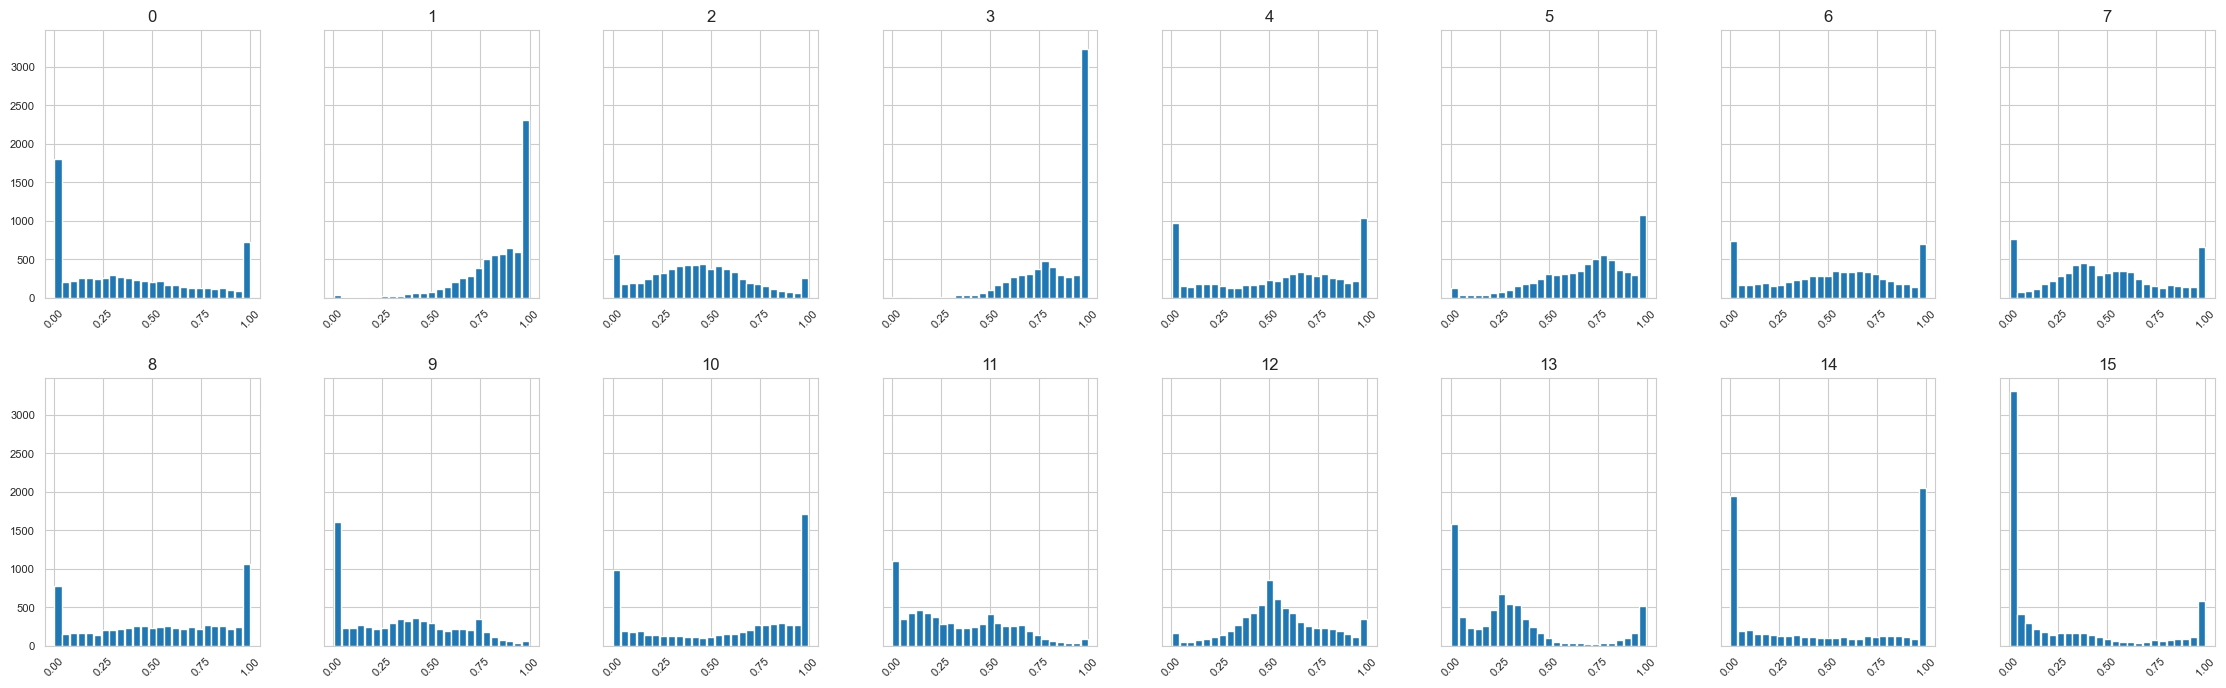

In [123]:
pendigits.x.hist(figsize=(28, 8), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(2, 8), sharey=True, zorder=2,
                 rwidth=0.9)

In [124]:
pendigits.y.describe()

,0
count,6870.000
mean,0.023
std,0.149
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [125]:
pendigits.y.value_counts()

0    6714
1     156
Name: count, dtype: int64

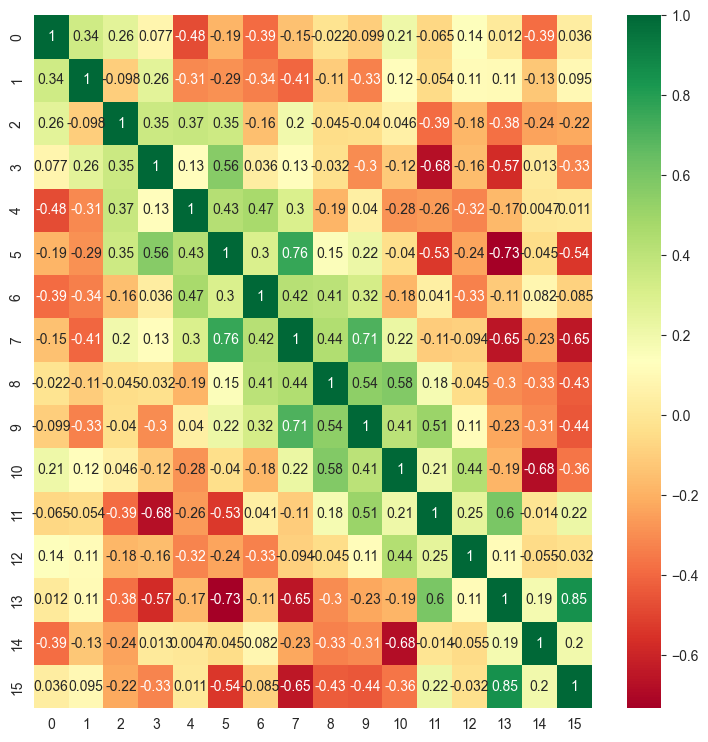

In [126]:
correlation_map(pendigits, figsize=(9, 9))

# Cardio dataset

In [128]:
cardio = datasets["cardio"]
cardio.x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.005,0.693,-0.204,0.595,0.353,-0.061,-0.278,-1.650,0.759,-0.42,0.372,1.486,-0.798,1.855,0.623,0.963,0.301,0.193,0.231,-0.290,-0.493
1,0.111,-0.080,-0.204,1.269,0.396,-0.061,-0.278,-1.710,0.759,-0.42,0.883,1.486,-0.798,1.855,0.279,0.963,0.301,0.129,0.094,-0.256,-0.493
2,0.217,-0.272,-0.204,1.051,0.149,-0.061,-0.278,-1.710,1.107,-0.42,2.517,1.142,-1.333,0.315,2.343,-0.488,0.061,0.065,0.025,-0.256,1.140
3,0.005,0.727,-0.204,1.212,-0.684,-0.061,-0.278,-1.710,1.107,-0.42,1.989,1.142,-1.333,0.315,1.655,-0.488,0.061,0.193,0.094,-0.323,1.140
4,-0.101,0.364,1.321,1.027,0.141,-0.061,-0.278,-0.992,-0.052,-0.42,0.798,-0.209,-0.086,-0.565,0.279,-0.488,-0.059,0.065,0.025,-0.457,1.140


In [129]:
cardio.x.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1831.000,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03,1.831e+03
mean,1.304e-15,-2.755e-16,1.785e-16,-1.521e-15,-4.812e-16,-3.881e-18,6.209e-17,0.000,-2.299e-15,1.552e-17,2.484e-15,1.513e-16,1.494e-16,6.054e-16,-1.358e-17,2.134e-17,1.397e-16,-3.260e-16,7.373e-16,-6.209e-17,3.105e-17
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00
min,-2.746e+00,-9.200e-01,-2.036e-01,-1.636e+00,-6.836e-01,-6.140e-02,-2.783e-01,-1.950,-1.441e+00,-4.205e-01,-1.398e+00,-1.877e+00,-1.440e+00,-2.325e+00,-1.441e+00,-4.883e-01,-4.568e+00,-3.829e+00,-4.113e+00,-6.906e-01,-2.127e+00
25%,-7.358e-01,-9.200e-01,-2.036e-01,-7.425e-01,-6.836e-01,-6.140e-02,-2.783e-01,-0.873,-7.465e-01,-4.205e-01,-6.832e-01,-8.704e-01,-9.053e-01,-6.753e-01,-7.534e-01,-4.883e-01,-5.402e-01,-5.731e-01,-6.651e-01,-5.904e-01,-4.933e-01
50%,4.912e-03,-2.873e-01,-2.036e-01,2.692e-02,-6.836e-01,-6.140e-02,-2.783e-01,-0.035,-1.674e-01,-4.205e-01,-1.215e-01,-2.318e-02,-5.000e-02,-7.032e-02,-6.538e-02,-4.883e-01,8.865e-04,6.542e-02,2.460e-02,-3.900e-01,-4.933e-01
75%,6.398e-01,6.604e-01,-1.605e-01,7.201e-01,5.243e-01,-6.140e-02,-2.783e-01,0.802,4.116e-01,-1.715e-01,4.913e-01,7.446e-01,8.766e-01,5.897e-01,6.226e-01,-4.883e-01,6.622e-01,7.039e-01,7.143e-01,1.778e-01,1.140e+00
max,2.968e+00,3.956e+00,9.929e+00,3.584e+00,4.317e+00,1.990e+01,8.587e+00,2.537,6.434e+00,5.243e+00,7.232e+00,2.810e+00,2.445e+00,4.055e+00,4.751e+00,1.403e+01,3.067e+00,3.130e+00,3.404e+00,8.294e+00,1.140e+00


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>,
        <Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>,
        <Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
        <Axes: title={'center': '8'}>, <Axes: title={'center': '9'}>,
        <Axes: title={'center': '10'}>],
       [<Axes: title={'center': '11'}>, <Axes: title={'center': '12'}>,
        <Axes: title={'center': '13'}>, <Axes: title={'center': '14'}>,
        <Axes: title={'center': '15'}>, <Axes: title={'center': '16'}>,
        <Axes: title={'center': '17'}>, <Axes: title={'center': '18'}>,
        <Axes: title={'center': '19'}>, <Axes: title={'center': '20'}>,
        <Axes: >]], dtype=object)

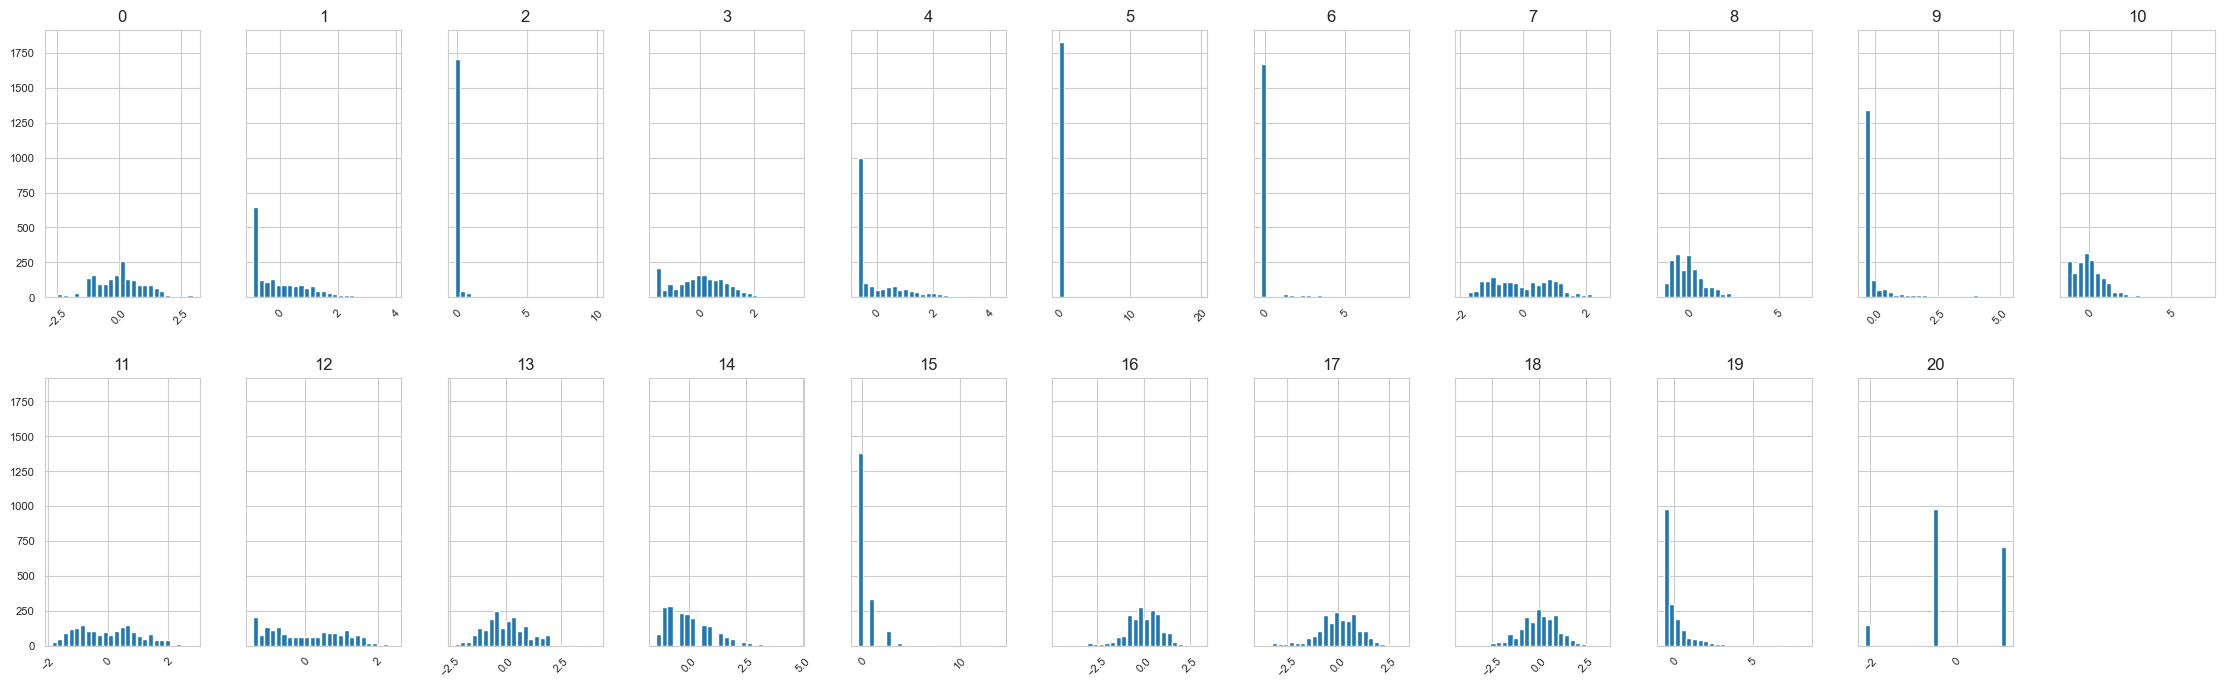

In [130]:
cardio.x.hist(figsize=(28, 8), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(2, 11), sharey=True, zorder=2,
              rwidth=0.9)

In [131]:
cardio.y.describe()

,0
count,1831.000
mean,0.096
std,0.295
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [132]:
pendigits.y.value_counts()

0    6714
1     156
Name: count, dtype: int64

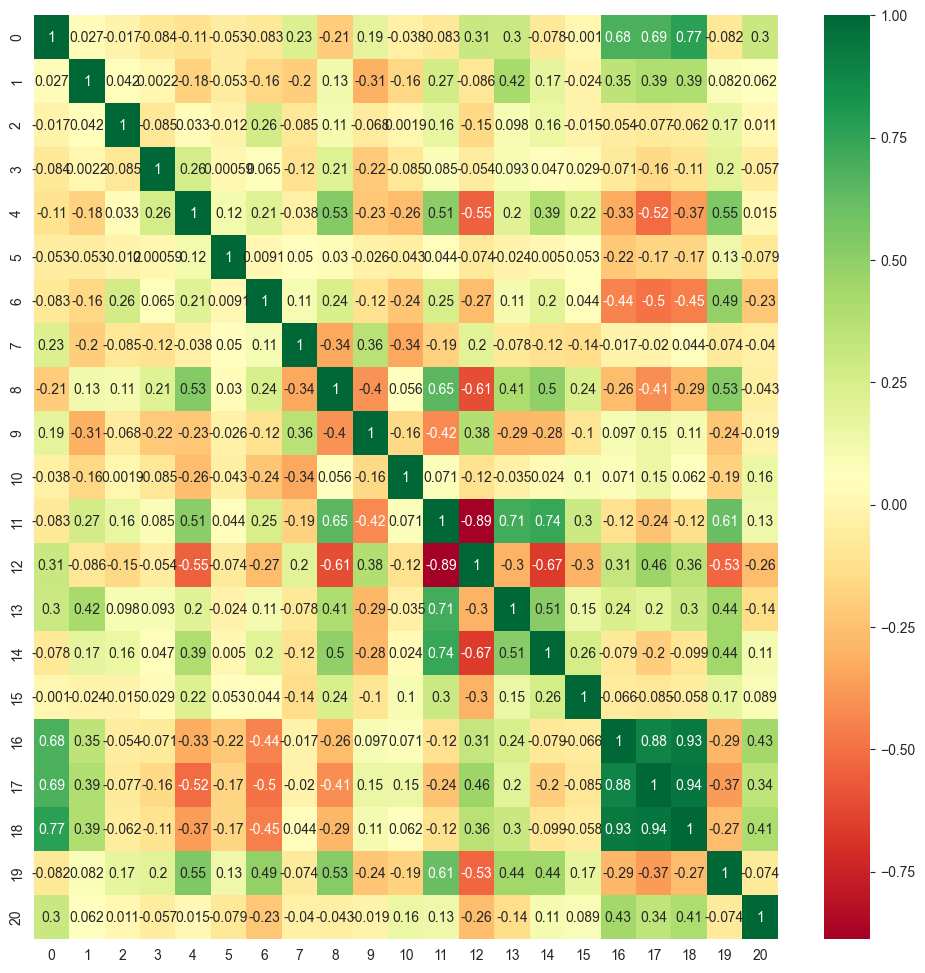

In [133]:
correlation_map(cardio, figsize=(12, 12))

# Local Outlier Factor

In [210]:
def preprocess_y(y: np.ndarray):
    return np.where(y == 1, 0, 1)

In [214]:
def local_outlier_factor(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    # model = LocalOutlierFactor(n_neighbors=5, novelty=False, contamination='auto')
    model = LocalOutlierFactor(
        n_neighbors=20, algorithm='auto',
        leaf_size=30, metric='minkowski',
        p=2, metric_params=None, contamination='auto'
    )
    model.fit(dataset.x_train)
    dataset.y_pred = DataFrame(preprocess_y(model.fit_predict(dataset.x_test)))
    dataset.scores_pred = DataFrame(model.negative_outlier_factor_)

    accuracy_report(dataset)

In [215]:
datasets = dataset_loader(dataset_names=('pima', 'pendigits', 'cardio'), verbose=False)

for dataset in datasets.values():
    local_outlier_factor(dataset)

******************************************* DATASET PIMA *******************************************

Number of errors : 308
Accuracy Score : 0.6331168831168831
Classification Report :
               precision    recall  f1-score   support

           0       0.64      0.95      0.77       194
           1       0.52      0.10      0.16       114

    accuracy                           0.63       308
   macro avg       0.58      0.52      0.46       308
weighted avg       0.60      0.63      0.54       308

**************************************** DATASET PENDIGITS *****************************************

Number of errors : 308
Accuracy Score : 0.9537845705967977
Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2681
           1       0.06      0.06      0.06        67

    accuracy                           0.95      2748
   macro avg       0.52      0.52      0.52      2748
weighted avg       0.95      

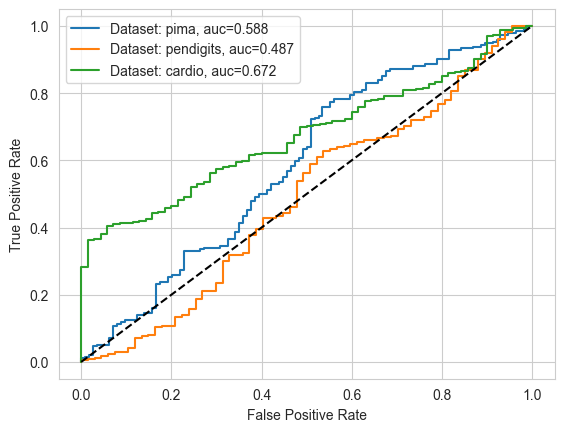

In [218]:
roc_curve_plot(datasets)

# Isolation Forest

In [219]:
def isolation_forest(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = IsolationForest(
        n_estimators=200,
        max_samples="auto",
        contamination="auto"
    )
    model.fit(dataset.x)
    dataset.y_pred = DataFrame(preprocess_y(model.predict(dataset.x_test)))
    dataset.scores_pred = DataFrame(model.decision_function(dataset.x_test))

    accuracy_report(dataset)


In [220]:
datasets = dataset_loader(dataset_names=('pima', 'pendigits', 'cardio'), verbose=False)

for name, dataset in datasets.items():
    isolation_forest(dataset)

******************************************* DATASET PIMA *******************************************

Number of errors : 308
Accuracy Score : 0.6785714285714286
Classification Report :
               precision    recall  f1-score   support

           0       0.69      0.91      0.79       200
           1       0.60      0.26      0.36       108

    accuracy                           0.68       308
   macro avg       0.64      0.58      0.57       308
weighted avg       0.66      0.68      0.64       308

**************************************** DATASET PENDIGITS *****************************************

Number of errors : 308
Accuracy Score : 0.616448326055313
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.61      0.76      2682
           1       0.06      1.00      0.11        66

    accuracy                           0.62      2748
   macro avg       0.53      0.80      0.43      2748
weighted avg       0.98      0

### ROC curve

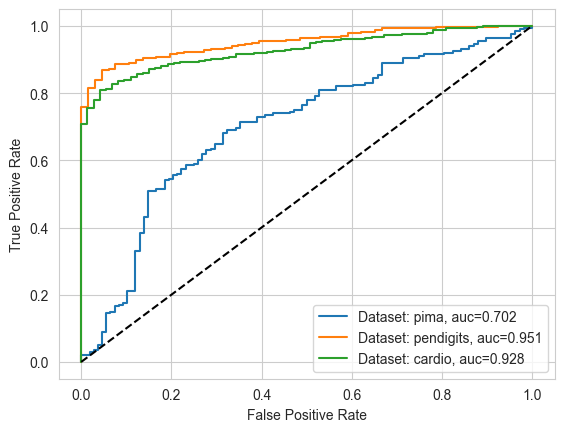

In [221]:
roc_curve_plot(datasets)

# k-Nearest Neighbors

In [67]:
def knn(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")

    model = NearestNeighbors(n_neighbors=5)
    model.fit(dataset.x)





    # distances and indexes of k-neaighbors from model outputs
    distances, indexes = model.kneighbors(dataset.x)
    # plot mean of k-distances of each observation
    plt.plot(distances.mean(axis =1))
    # dataset.y_pred = DataFrame(preprocess_y(model.predict(dataset.x)))
    # dataset.scores_pred = model.predict_proba(dataset.x)[:, 1]
    print(distances)
    print(indexes)
    outlier_index = np.where(distances.mean(axis = 1) > 0.15)
    # print(outlier_index)
    # dataset.y_pred = dataset.y.to_numpy().copy()[:] = 0
    # dataset.y_pred[outlier_index] = 1
    accuracy_report(dataset)

In [223]:
def knn(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    contamination=0.91
    model = NearestNeighbors(n_neighbors=5)
    model.fit(dataset.x_train)

    dataset.scores_pred = distances = DataFrame(model.kneighbors(dataset.x_test)[0][:, -1])
    threshold_ = np.percentile(distances, (1 - contamination) * 100)
    dataset.y_pred = DataFrame(distances < threshold_, dtype=int)

    accuracy_report(dataset)


In [224]:
datasets = dataset_loader(dataset_names=('pima', 'pendigits', 'cardio'), verbose=False)

for name, dataset in datasets.items():
    knn(dataset)

******************************************* DATASET PIMA *******************************************

Number of errors : 308
Accuracy Score : 0.6233766233766234
Classification Report :
               precision    recall  f1-score   support

           0       0.66      0.90      0.76       206
           1       0.25      0.07      0.11       102

    accuracy                           0.62       308
   macro avg       0.46      0.48      0.43       308
weighted avg       0.52      0.62      0.54       308

**************************************** DATASET PENDIGITS *****************************************

Number of errors : 308
Accuracy Score : 0.88391557496361
Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      2677
           1       0.00      0.00      0.00        71

    accuracy                           0.88      2748
   macro avg       0.49      0.45      0.47      2748
weighted avg       0.95      0.

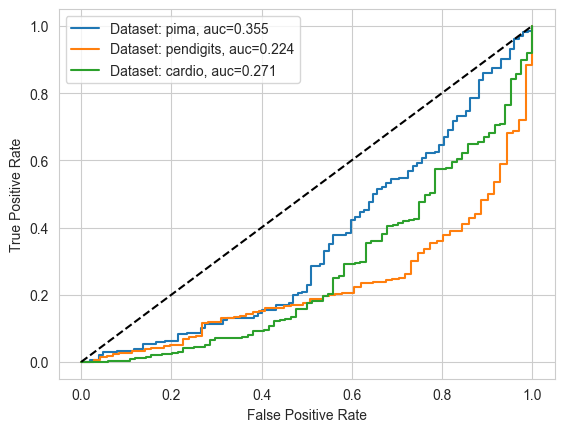

In [225]:
roc_curve_plot(datasets)

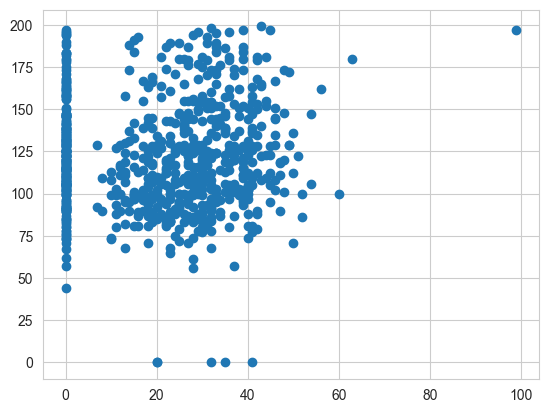

In [41]:

plt.scatter(pima.x[3][:], pima.x[1][:])
plt.show()